## Import modules and data uploading

In [40]:
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras.utils import np_utils
import json
from PIL import Image
import os

import scipy

In [28]:
def plot_loss(history):
    plt.figure(figsize=(12, 5))
    epochs = np.arange(1, len(history.history['loss']) + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss']
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')

    plt.tight_layout()
    plt.show()

In [31]:
def plot_accuracy(history):
    plt.figure(figsize=(12, 5))
    epochs = np.arange(1, len(history.history['accuracy']) + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [2]:
data_dir = "dataset_malaysian_coins"

data_train_path =  data_dir + '/train'
data_test_path =  data_dir + '/test'

In [3]:
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

datagen_test = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    rescale=1./255)

test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 1598 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1463: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  "This ImageDataGenerator specifies "
C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1472: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  "This ImageDataGenerator specifies "


## MobileNetV2

In [56]:
from keras.applications import MobileNetV2, ResNet50, InceptionV3, EfficientNetB0
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model


input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=(224, 224, 3),
    pooling='avg')
    
fine_tune_at = 100

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
    
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = base_model.output
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [57]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [58]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

num_train = len(train_generator.filenames)
num_test = len(test_generator.filenames)

history = model.fit(
    train_generator,
    steps_per_epoch=num_train//batch_size,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=num_test//batch_size)

Epoch 1/10
49/49 [==============================] - 54s 1s/step - loss: 1.1043 - accuracy: 0.5089 - val_loss: 1.0291 - val_accuracy: 0.5677
Epoch 2/10
49/49 [==============================] - 48s 988ms/step - loss: 0.6743 - accuracy: 0.7222 - val_loss: 0.8387 - val_accuracy: 0.6589
Epoch 3/10
49/49 [==============================] - 52s 1s/step - loss: 0.4770 - accuracy: 0.8059 - val_loss: 0.8534 - val_accuracy: 0.6615
Epoch 4/10
49/49 [==============================] - 51s 1s/step - loss: 0.3703 - accuracy: 0.8512 - val_loss: 0.7786 - val_accuracy: 0.7083
Epoch 5/10
49/49 [==============================] - 52s 1s/step - loss: 0.3012 - accuracy: 0.8895 - val_loss: 0.9045 - val_accuracy: 0.7240
Epoch 6/10
49/49 [==============================] - 54s 1s/step - loss: 0.2431 - accuracy: 0.9036 - val_loss: 0.9011 - val_accuracy: 0.7578
Epoch 7/10
49/49 [==============================] - 63s 1s/step - loss: 0.1949 - accuracy: 0.9209 - val_loss: 1.3034 - val_accuracy: 0.6797
Epoch 8/10
49/49 

In [59]:
model.save('ml_model_mobilenet_1_improved')

INFO:tensorflow:Assets written to: ml_model_mobilenet_2\assets


INFO:tensorflow:Assets written to: ml_model_mobilenet_2\assets


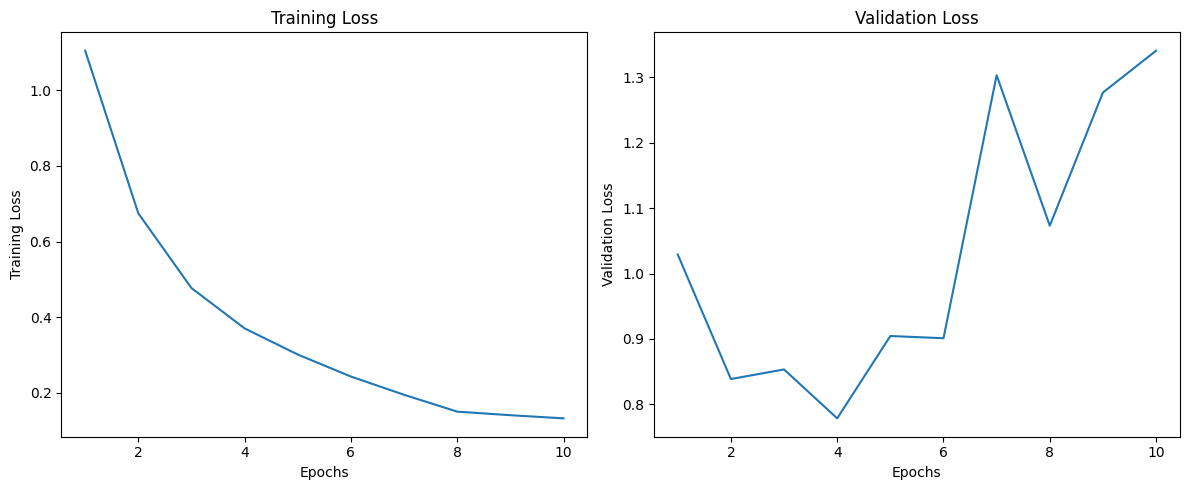

In [60]:
plot_loss(history)

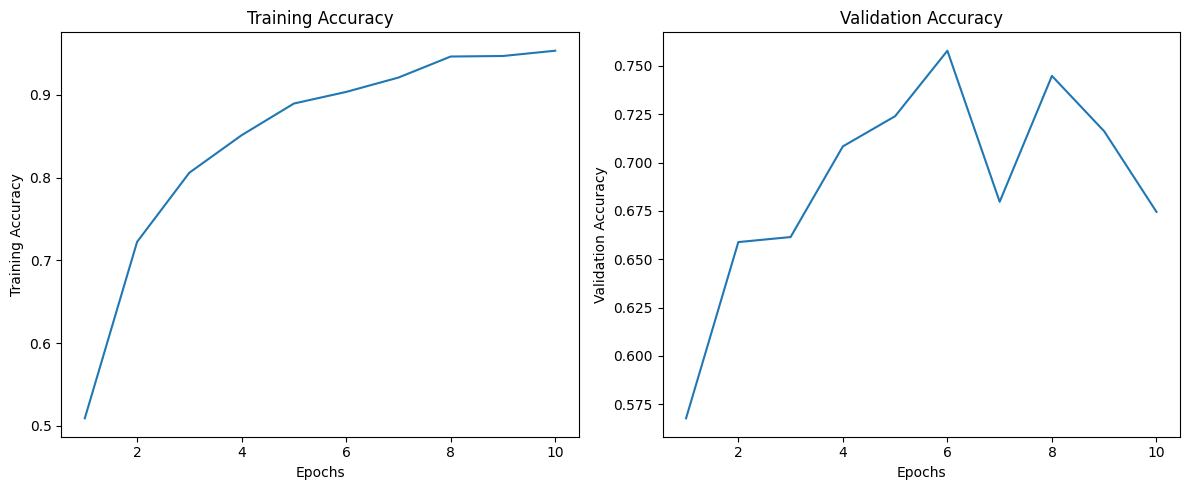

In [61]:
plot_accuracy(history)

## GoogLeNet

In [62]:
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=(224, 224, 3),
    pooling='avg')
    
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
    
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = base_model.output
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [63]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [64]:
num_train = len(train_generator.filenames)
num_test = len(test_generator.filenames)

history = model.fit(
    train_generator,
    steps_per_epoch=num_train//batch_size,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=num_test//batch_size)

C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/10
49/49 [==============================] - 74s 1s/step - loss: 1.0850 - accuracy: 0.5294 - val_loss: 1.1213 - val_accuracy: 0.5781
Epoch 2/10
49/49 [==============================] - 71s 1s/step - loss: 0.6064 - accuracy: 0.7452 - val_loss: 1.0414 - val_accuracy: 0.6771
Epoch 3/10
49/49 [==============================] - 72s 1s/step - loss: 0.3994 - accuracy: 0.8365 - val_loss: 1.0610 - val_accuracy: 0.7214
Epoch 4/10
49/49 [==============================] - 73s 1s/step - loss: 0.3067 - accuracy: 0.8863 - val_loss: 0.7998 - val_accuracy: 0.7448
Epoch 5/10
49/49 [==============================] - 80s 2s/step - loss: 0.2467 - accuracy: 0.9106 - val_loss: 0.7486 - val_accuracy: 0.7812
Epoch 6/10
49/49 [==============================] - 87s 2s/step - loss: 0.1975 - accuracy: 0.9310 - val_loss: 0.7001 - val_accuracy: 0.7943
Epoch 7/10
49/49 [==============================] - 82s 2s/step - loss: 0.1656 - accuracy: 0.9438 - val_loss: 0.8322 - val_accuracy: 0.7917
Epoch 8/10
49/49 [==

In [65]:
model.save('ml_model_googlenet_1_improved')

INFO:tensorflow:Assets written to: ml_model_googlenet_1\assets


INFO:tensorflow:Assets written to: ml_model_googlenet_1\assets


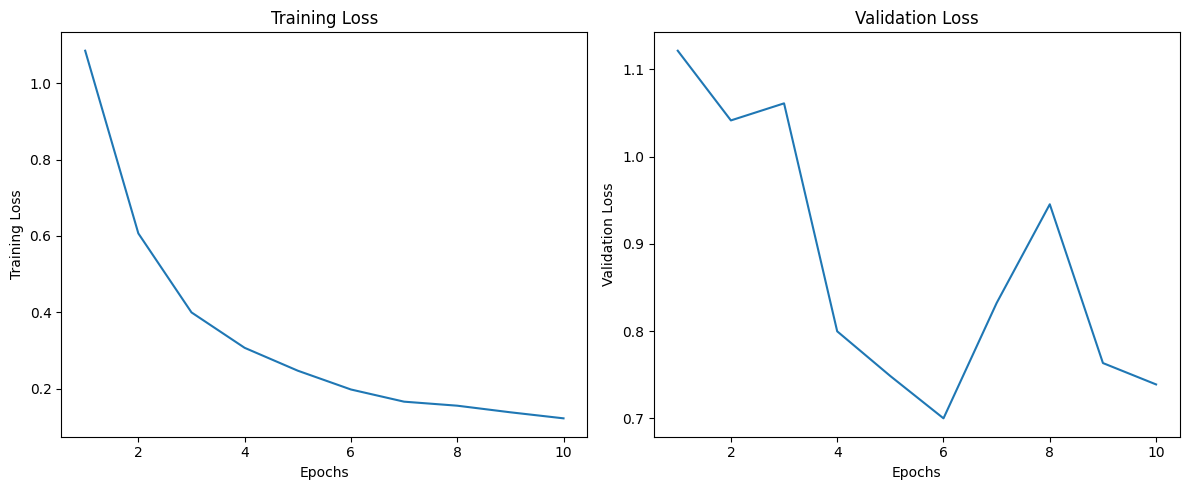

In [66]:
plot_loss(history)

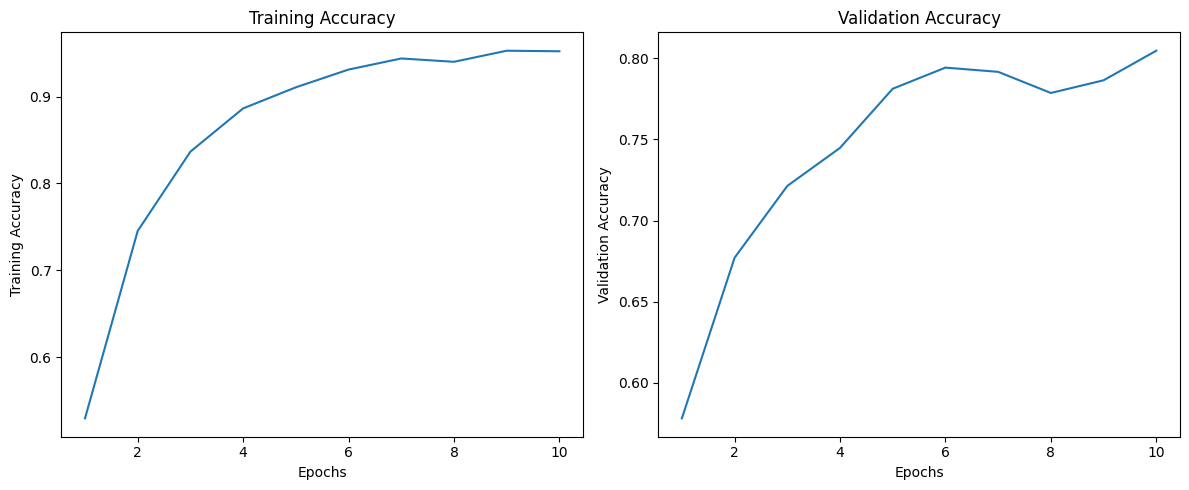

In [67]:
plot_accuracy(history)

## ResNet50

In [47]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=(224, 224, 3),
    pooling='avg')

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
    
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

x = base_model.output
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [48]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
num_train = len(train_generator.filenames)
num_test = len(test_generator.filenames)

history = model.fit(
    train_generator,
    steps_per_epoch=num_train//batch_size,
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=num_test//batch_size)

C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
C:\Users\maksym\anaconda3\envs\ml\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/10
49/49 [==============================] - 77s 1s/step - loss: 1.0297 - accuracy: 0.5619 - val_loss: 1.2218 - val_accuracy: 0.5781
Epoch 2/10
49/49 [==============================] - 73s 1s/step - loss: 0.6005 - accuracy: 0.7516 - val_loss: 0.8362 - val_accuracy: 0.6927
Epoch 3/10
49/49 [==============================] - 82s 2s/step - loss: 0.4787 - accuracy: 0.7995 - val_loss: 0.5925 - val_accuracy: 0.7448
Epoch 4/10
49/49 [==============================] - 76s 2s/step - loss: 0.3821 - accuracy: 0.8455 - val_loss: 0.6568 - val_accuracy: 0.7578
Epoch 5/10
49/49 [==============================] - 80s 2s/step - loss: 0.3419 - accuracy: 0.8570 - val_loss: 0.7773 - val_accuracy: 0.7865
Epoch 6/10
49/49 [==============================] - 100s 2s/step - loss: 0.3381 - accuracy: 0.8627 - val_loss: 0.7158 - val_accuracy: 0.7734
Epoch 7/10
49/49 [==============================] - 88s 2s/step - loss: 0.2705 - accuracy: 0.8921 - val_loss: 0.7871 - val_accuracy: 0.7734
Epoch 8/10
49/49 [=

In [50]:
model.save('ml_model_resnet50_1_improved')

INFO:tensorflow:Assets written to: ml_model_resnet50_2\assets


INFO:tensorflow:Assets written to: ml_model_resnet50_2\assets


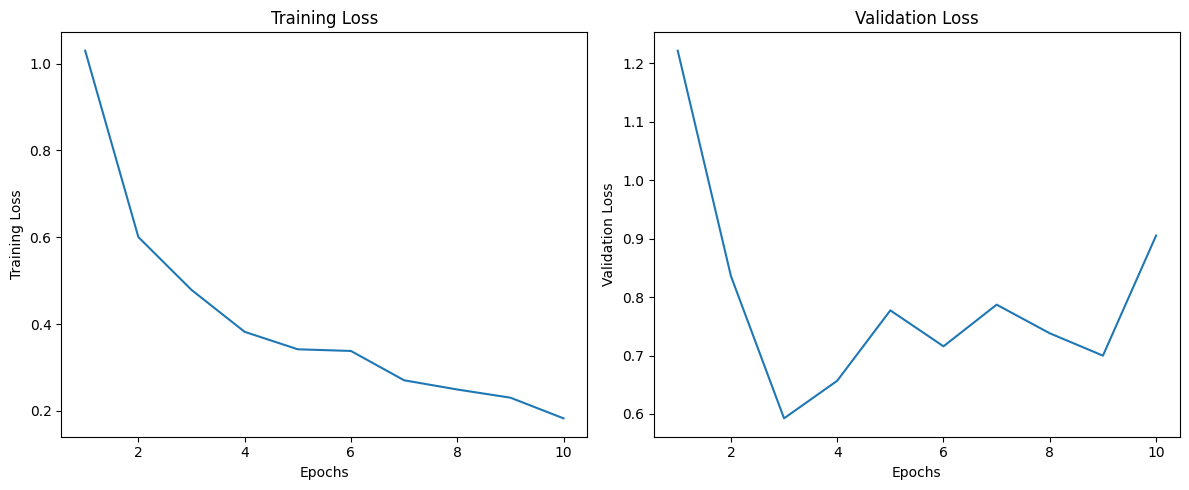

In [51]:
plot_loss(history)

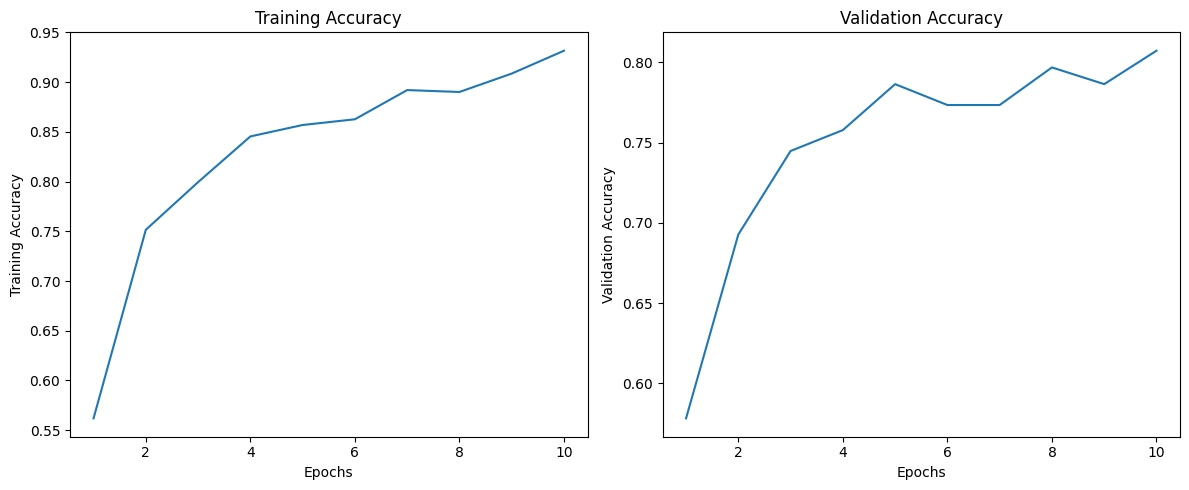

In [52]:
plot_accuracy(history)